## Classifying Clapper Rails and King Rails Based on their Kek Calls

This project will analyze acoustic markers derived from audio recordings of Clapper Rails and King Rails in an attempt to classify the species.  
Sample sounds from these call can be listened to at The Cornell Lab:
 - Clapper Rail Sounds: https://www.allaboutbirds.org/guide/Clapper_Rail/sounds
 - King Rail Sounds: https://www.allaboutbirds.org/guide/King_Rail/sounds

Original work on this dataset is documented at the Wiley Online Library: https://onlinelibrary.wiley.com/doi/10.1002/ece3.4711  
A copy of this research is also included in this git repository as "Ecology and Evolution - 2018 - Stiffler.pdf"

During this analysis we will review the following questions:
 - Can we reproduce the basic findings regarding optimal machine learning models for this classification?
 - Are there improvements that can be made in the outcomes?

https://github.com/carl-schick-ds/rails.git

***
### Setup
Import needed libraries.  Unless otherwise noted, all libraries are available in the baseline conda environment.

In [780]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
from IPython.display import display

***
### Data Collection
Data collection was not required for this project since the original dataset is available online in CSV format and is included in this repository as "KIRACLRA.csv".  
I reached out to the original researches in an attempt to obtain the source audio recordings that were used to produce the audio markers in the dataset, but those recordings are no longer available.  

It's feasible that improvements could be made to the classification model by using different audio markers, but this is beyond the scope of this analysis and, in any regard, is not possible due to the unavailability of the source audio recordings.

### Data Loading and Cleaning

#### Load CSVs
Load the data from the csv files and run a quick review of the data for validity checks

In [781]:
rails_df = pd.read_csv('KIRACLRA.csv')
rails_df.head()

,Species,Peak Freq (Hz),Q1 Freq (Hz),Q3 Freq (Hz),IQR BW (Hz),Freq 5% (Hz),Freq 95% (Hz),BW 90% (Hz)
0,CLRA,2601.6,2437.5,2976.6,539.1,1851.6,4031.2,2179.7
1,CLRA,2882.8,2671.9,3234.4,562.5,1992.2,4125.0,2132.8
2,CLRA,1500.0,1593.8,2953.1,1359.4,1500.0,4804.7,3304.7
3,CLRA,2507.8,2507.8,3656.2,1148.4,1664.1,4851.6,3187.5
4,CLRA,2953.1,2765.6,3703.1,937.5,2015.6,4453.1,2437.5


In [782]:
rails_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Species         960 non-null    object 
 1   Peak Freq (Hz)  960 non-null    float64
 2   Q1 Freq (Hz)    960 non-null    float64
 3   Q3 Freq (Hz)    960 non-null    float64
 4   IQR BW (Hz)     960 non-null    float64
 5   Freq 5% (Hz)    960 non-null    float64
 6   Freq 95% (Hz)   960 non-null    float64
 7   BW 90% (Hz)     960 non-null    float64
dtypes: float64(7), object(1)
memory usage: 60.1+ KB


***
Generate descriptive statistics for both the Clapper Rail and King Rail recordings.  
These were compared back to the original research to confirm we are starting from the same place.
***

In [783]:
print("Clapper Rails Descriptive Statistics")
display(rails_df[rails_df['Species'] == 'CLRA'].describe().round(decimals=0).astype(int))
print("King Rails Descriptive Statistics")
display(rails_df[rails_df['Species'] == 'KIRA'].describe().round(decimals=0).astype(int))

Clapper Rails Descriptive Statistics


,Peak Freq (Hz),Q1 Freq (Hz),Q3 Freq (Hz),IQR BW (Hz),Freq 5% (Hz),Freq 95% (Hz),BW 90% (Hz)
count,480,480,480,480,480,480,480
mean,2824,2482,3284,801,1979,4175,2196
std,520,327,403,392,273,563,639
min,1500,1594,2484,70,1500,2883,773
25%,2578,2291,2930,516,1805,3744,1734
50%,2742,2508,3258,773,1922,4312,2250
75%,3053,2648,3498,1008,2180,4664,2771
max,4852,3539,4664,2344,2812,4969,3398


King Rails Descriptive Statistics


,Peak Freq (Hz),Q1 Freq (Hz),Q3 Freq (Hz),IQR BW (Hz),Freq 5% (Hz),Freq 95% (Hz),BW 90% (Hz)
count,480,480,480,480,480,480,480
mean,2808,2556,3254,698,2096,3997,1901
std,476,309,530,467,333,587,683
min,1550,1572,2304,65,1507,2692,581
25%,2541,2433,2885,388,1809,3467,1351
50%,2756,2562,3112,581,2132,4059,1873
75%,2993,2735,3488,861,2347,4457,2455
max,4802,3316,4802,2778,3036,4974,3424


#### Clean the Data

Confirm the target column, Species, review the counts, rename the values, and reset the column as a categorical type.

In [784]:
## Define our Categorical Dtype in order to ensure the Clapper Species is the positive value during classification
species_cat = CategoricalDtype(categories=['King', 'Clapper'], ordered=True)  

print(rails_df['Species'].value_counts())
rails_df['Species'] = rails_df['Species'].apply(lambda x: 'Clapper' if x == 'CLRA' else 'King')
rails_df['Species'] = rails_df['Species'].astype(species_cat)
print(rails_df['Species'].value_counts())
# print()
# print(rails_df['Species'].cat.codes)
print()
display(rails_df.info())

CLRA    480
KIRA    480
Name: Species, dtype: int64
King       480
Clapper    480
Name: Species, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Species         960 non-null    category
 1   Peak Freq (Hz)  960 non-null    float64 
 2   Q1 Freq (Hz)    960 non-null    float64 
 3   Q3 Freq (Hz)    960 non-null    float64 
 4   IQR BW (Hz)     960 non-null    float64 
 5   Freq 5% (Hz)    960 non-null    float64 
 6   Freq 95% (Hz)   960 non-null    float64 
 7   BW 90% (Hz)     960 non-null    float64 
dtypes: category(1), float64(7)
memory usage: 53.7 KB


None

***
Review the correlation of the parameters to determine if any parameters can be dropped in order to simply the models.  
Generate both a correlation table and a heatmap.
***

In [785]:
corr = rails_df.corr()
display(corr)

,Peak Freq (Hz),Q1 Freq (Hz),Q3 Freq (Hz),IQR BW (Hz),Freq 5% (Hz),Freq 95% (Hz),BW 90% (Hz)
Peak Freq (Hz),1.000000,0.564438,0.510591,0.138000,0.253712,0.206635,0.061446
Q1 Freq (Hz),0.564438,1.000000,0.450016,-0.248563,0.630123,0.183953,-0.130135
Q3 Freq (Hz),0.510591,0.450016,1.000000,0.753137,0.135469,0.593003,0.447317
IQR BW (Hz),0.138000,-0.248563,0.753137,1.000000,-0.317256,0.507690,0.581049
Freq 5% (Hz),0.253712,0.630123,0.135469,-0.317256,1.000000,-0.068072,-0.515680
Freq 95% (Hz),0.206635,0.183953,0.593003,0.507690,-0.068072,1.000000,0.889897
BW 90% (Hz),0.061446,-0.130135,0.447317,0.581049,-0.515680,0.889897,1.000000


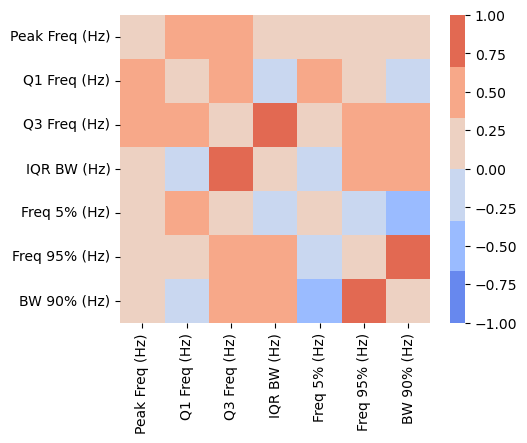

In [786]:
# Set the self-correlation cells (the diaganols) to zero to minimize their prominence during visual review
np.fill_diagonal(corr.values, 0)

# Set the palette to 'coolwarm' and the min/max to the extreme ends of valid correlation values
colormap = sns.color_palette("coolwarm")
vmin, vmax = (-1, 1)

# Display the heatmap
sns.heatmap(corr, center=(vmin + vmax) / 2, vmin=vmin, vmax=vmax, cmap=colormap)
'';

Both the correlation table and the heatmap indicate a strong correlation between the Bandwidth (BW) markers and one of the Frequency ranges.  
Specifically, `IGR BW (Hz)` is highly correlated with `Q3 Freq Hz` (*r* $\approx$ .75) and `BW 90% (Hz)` is highly correlated with `Freq 95% (Hz)` (*r* $\approx$ .89)  

<mark>Is this next statement true?  I ran most of the models with and without the Bandwidth columns and the results were similar or worse when they were included.  
Are there considerations other than the *r* value that I should be reviewing for the claims below?</mark>  

Parameters with correlations above .70 - .75 will have a negligible impact on the model results since their values are appropriately accounted for in another parameter.  At times, their inclusion could actually produce worse outcomes since they can add unnecessary noise to the model generation.  For this reason, we will drop both of the Bandwidth (BW) markers from the dataset.  

***
Drop the Bandwidth (BW) columns due to their high correlation with other parameters.
***

In [787]:
rails_df.drop(['IQR BW (Hz)', 'BW 90% (Hz)'], axis=1, inplace=True)
display(rails_df.head())

,Species,Peak Freq (Hz),Q1 Freq (Hz),Q3 Freq (Hz),Freq 5% (Hz),Freq 95% (Hz)
0,Clapper,2601.6,2437.5,2976.6,1851.6,4031.2
1,Clapper,2882.8,2671.9,3234.4,1992.2,4125.0
2,Clapper,1500.0,1593.8,2953.1,1500.0,4804.7
3,Clapper,2507.8,2507.8,3656.2,1664.1,4851.6
4,Clapper,2953.1,2765.6,3703.1,2015.6,4453.1


### Data Exploration

#### Visualize Parameter Realtionships with Species Classification
The relationship of each parameter with the Species classification is visualized in a variety of formats: historgrams, boxplots, violinplots, and scatterplots.

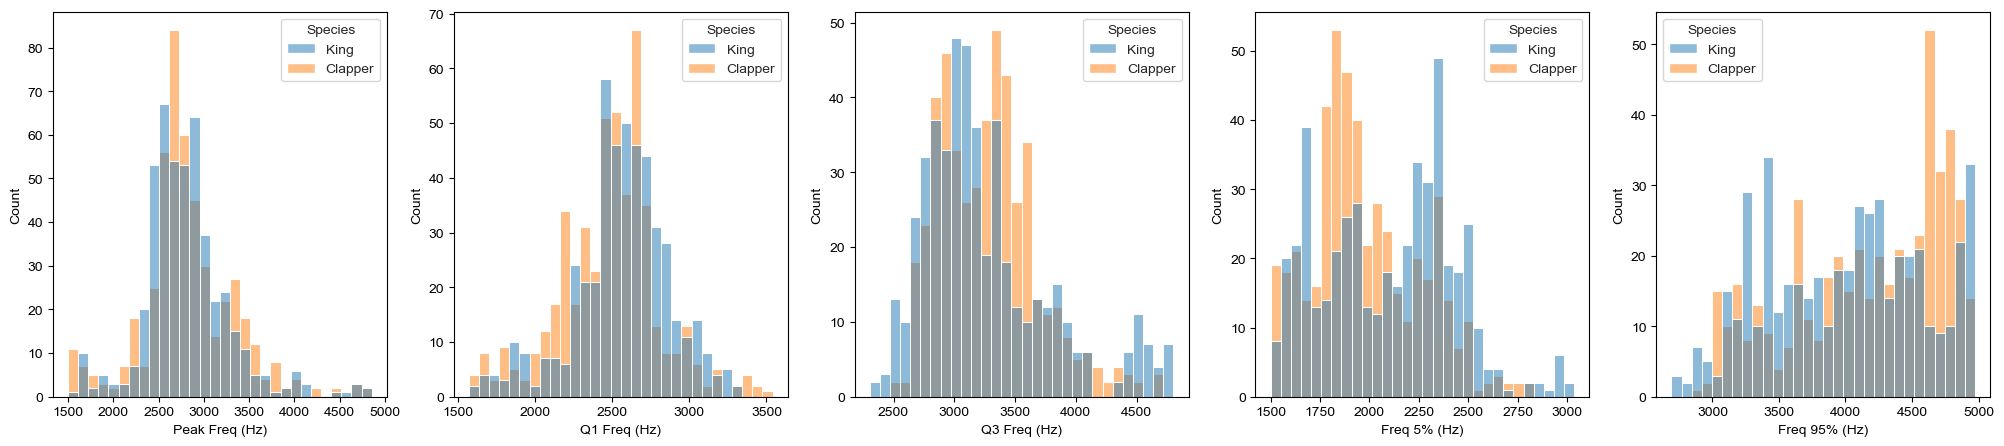

In [788]:
fig, axes = plt.subplots(1,5, figsize=(25,5))
sns.set_style('whitegrid')
sns.histplot(data=rails_df, x='Peak Freq (Hz)', bins = 30, hue='Species', ax=axes[0])
sns.histplot(data=rails_df, x='Q1 Freq (Hz)', bins = 30, hue='Species', ax=axes[1])
sns.histplot(data=rails_df, x='Q3 Freq (Hz)', bins = 30, hue='Species', ax=axes[2])
sns.histplot(data=rails_df, x='Freq 5% (Hz)', bins = 30, hue='Species', ax=axes[3])
sns.histplot(data=rails_df, x='Freq 95% (Hz)', bins = 30, hue='Species', ax=axes[4])
'';

<AxesSubplot:xlabel='Freq 95% (Hz)', ylabel='Species'>

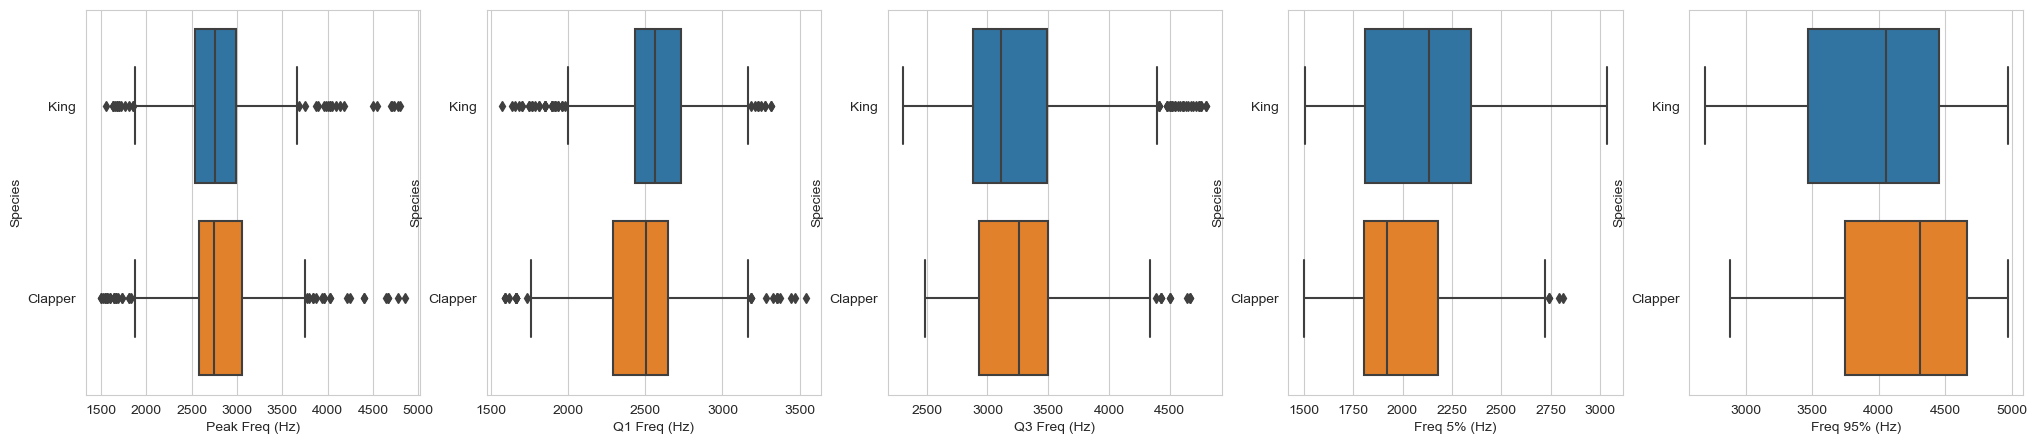

In [789]:
fig, axes = plt.subplots(1,5, figsize=(25,5))
sns.set_style('whitegrid')
sns.boxplot(data=rails_df, x='Peak Freq (Hz)', y='Species', ax=axes[0])
sns.boxplot(data=rails_df, x='Q1 Freq (Hz)', y='Species', ax=axes[1])
sns.boxplot(data=rails_df, x='Q3 Freq (Hz)', y='Species', ax=axes[2])
sns.boxplot(data=rails_df, x='Freq 5% (Hz)', y='Species', ax=axes[3])
sns.boxplot(data=rails_df, x='Freq 95% (Hz)', y='Species', ax=axes[4])

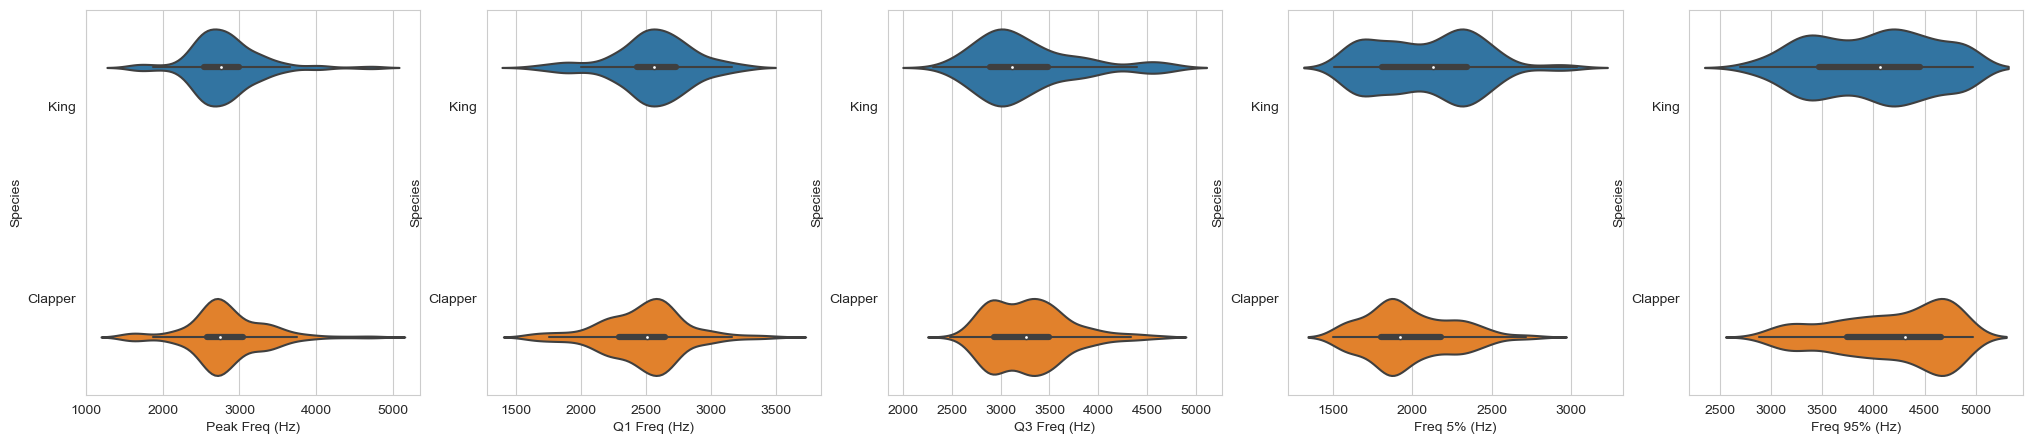

In [790]:
fig, axes = plt.subplots(1,5, figsize=(25,5))
sns.set_style('whitegrid')
sns.violinplot(data=rails_df, x='Peak Freq (Hz)', y='Species', hue='Species', legend=False, ax=axes[0])
sns.violinplot(data=rails_df, x='Q1 Freq (Hz)', y='Species', hue='Species', legend=False, ax=axes[1])
sns.violinplot(data=rails_df, x='Q3 Freq (Hz)', y='Species', hue='Species', legend=False, ax=axes[2])
sns.violinplot(data=rails_df, x='Freq 5% (Hz)', y='Species', hue='Species', legend=False, ax=axes[3])
sns.violinplot(data=rails_df, x='Freq 95% (Hz)', y='Species', hue='Species', legend=False, ax=axes[4])

for i in range(len(axes)):
    axes[i].legend().remove()
'';

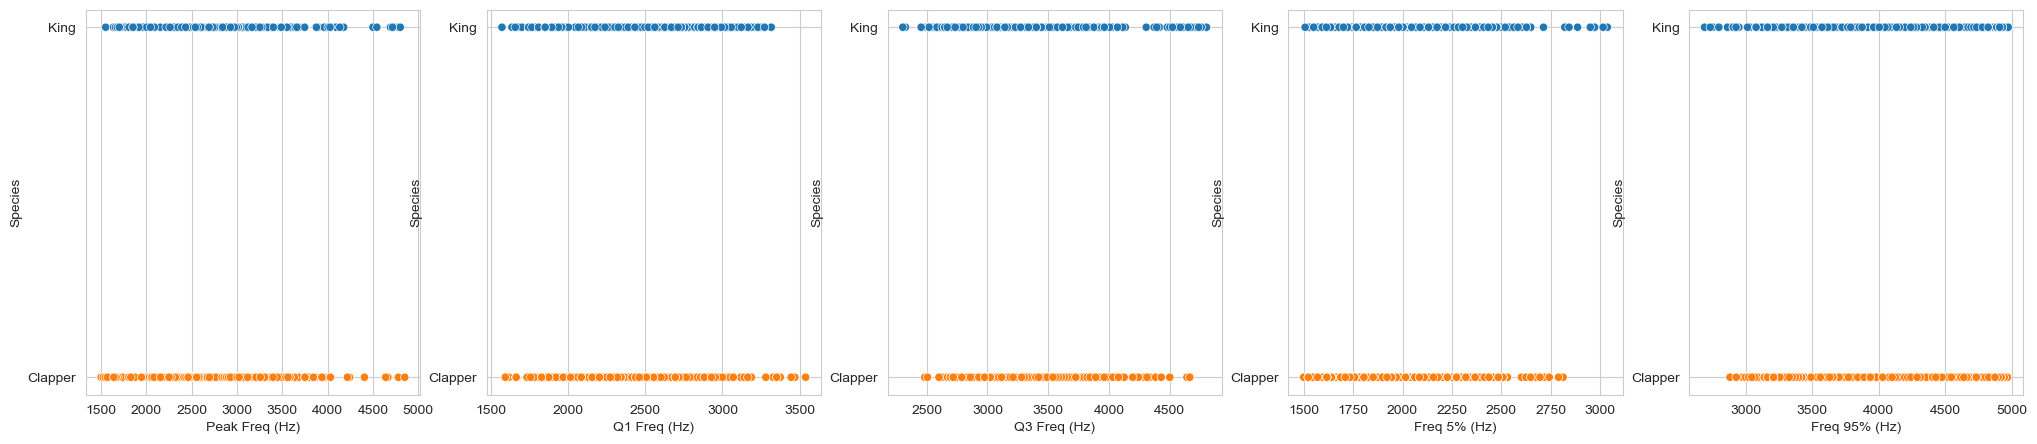

In [791]:
fig, axes = plt.subplots(1,5, figsize=(25,5))
sns.set_style('whitegrid')
sns.scatterplot(data=rails_df, x='Peak Freq (Hz)', y='Species', hue='Species', legend=False, ax=axes[0])
sns.scatterplot(data=rails_df, x='Q1 Freq (Hz)', y='Species', hue='Species', legend=False, ax=axes[1])
sns.scatterplot(data=rails_df, x='Q3 Freq (Hz)', y='Species', hue='Species', legend=False, ax=axes[2])
sns.scatterplot(data=rails_df, x='Freq 5% (Hz)', y='Species', hue='Species', legend=False, ax=axes[3])
sns.scatterplot(data=rails_df, x='Freq 95% (Hz)', y='Species', hue='Species', legend=False, ax=axes[4])
'';

<mark>
I could use some help interpreting the above visualizations.  At a high level, it looks like there is a lot of overlap between the data values and the Species class, which would make modeling difficult.  The histograms show some bright spots, where some parameters (Freq 5% and Freq 95% in particular) clearly have values with higher occurrences in one species vs. another.  
<br>
<br>
But in general, how should I be interpreting this?  Does it give any indication of which model type, or which model in particular, would be best?  I'm not sure what the clear takeaways are, or whether I should be exploring anything differently in order to guide model selection.
</mark>  

### Modeling Preparation

While not a huge variation in the range of the numeric values for the parameters, it' still a good idea to normalize the data.  
We will use a standard scaler for normalization, where `new_value = (orig_value - mean) / std-dev`.  

**Note: This scaling was not done during the original study and may help with yielding improved results.**

In addition, let's extract the features and target into generic X and y variables.

In [792]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(rails_df.drop('Species', axis=1)), columns=rails_df.drop('Species', axis=1).columns)
# X = rails_df.drop('Species', axis=1)
y = rails_df['Species']

***
Split the data into test and train datasets, with 30% reserved for testing.
***

In [793]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=77)

***
Import the methods we will use for model evaluation
***

In [794]:
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay
plt.style.use('default')

### Original Outcomes
For reference, the outcomes from the original study are shown in the image below.

![](orig_outcomes.jpg)



### Model Selection

#### Parametric Models

***
Linear Discriminant Analysis
***

Coefficients: 
 [[-0.23269251  0.25852373  0.16133604  0.3107212  -0.43497169]]
Intercept: 
 [0.038752]
Score: 0.582
AUC: 0.654


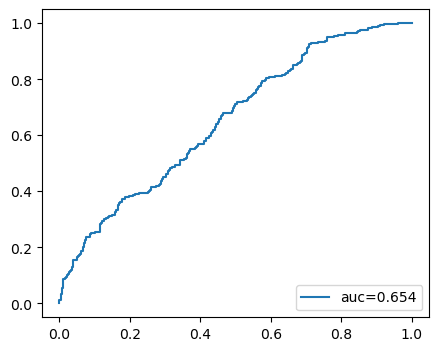

In [809]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## LDR
ldr = LinearDiscriminantAnalysis()
ldr.fit(X_train,y_train)

# Get predicted probabilities
# Although Clapper is the positive class, it's the first class returned by predict_proba
y_pred_proba = ldr.predict_proba(X_train)
y_pred_proba_Clapper = ldr.predict_proba(X_train)[::,0]
y_pred_proba_King = ldr.predict_proba(X_train)[::,1]

# The coefficients and intercept
print("Coefficients: \n", ldr.coef_)
print("Intercept: \n", ldr.intercept_)

# Model Score
fpr, tpr, thresholds = roc_curve(y_train,  y_pred_proba_Clapper, pos_label='Clapper')
print("Score:", '{:.3f}'.format(round(ldr.score(X_train, y_train),3)))
print("AUC:", '{:.3f}'.format(round(auc(fpr, tpr), 3)))

plt.rcParams["figure.figsize"] = (5,4)
plt.plot(fpr,tpr,label="auc="+str(round(auc(fpr, tpr), 3)))
plt.legend(loc=4)
'';

Accuracy: 0.524
Precision: 0.540
Sensitivity: 0.456
Specificity: 0.596
AUC: 0.585
K: 0.051


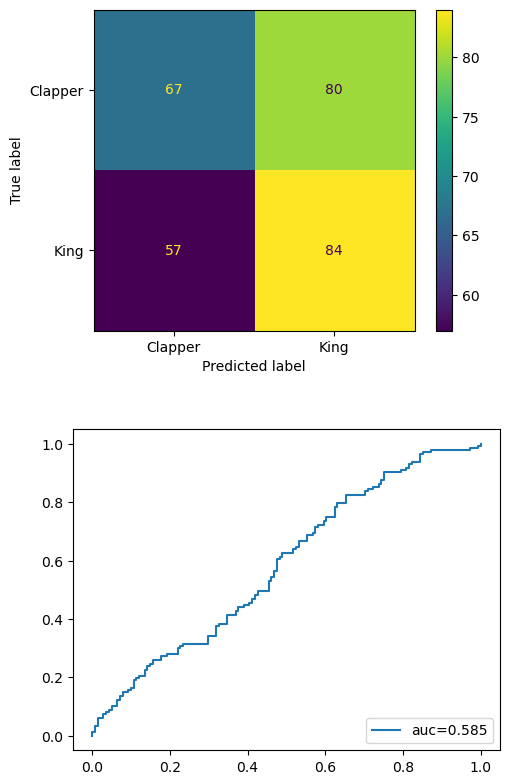

In [796]:
predictions = ldr.predict(X_test)

# Get predicted probabilities
# Although Clapper is the positive class, it's the first class returned by predict_proba
y_pred_proba = ldr.predict_proba(X_test)
y_pred_proba_Clapper = ldr.predict_proba(X_test)[::,0]
y_pred_proba_King = ldr.predict_proba(X_test)[::,1]

# Commented code below helped confirm that 'Clapper' is the Positive Label
# test_df = pd.DataFrame(y_pred_proba)
# test_df['Positive'] = test_df[0].apply(lambda x: True if x >= .5 else False)
# print(test_df['Positive'].sum())
# Result was 124, which equals the number of Clapper predications in the Confusion Matrix

### Sensitivity - recall of the positive class (Clapper), ie. True Positive (TP)
### Specificity - recall of the negative class (King), ie. True Negative (TN)

class_rpt = classification_report(y_test, predictions, digits=3, output_dict=True)
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba_Clapper, pos_label='Clapper')
scr_accuracy = round(class_rpt['accuracy'],3)
scr_precision = round(class_rpt['Clapper']['precision'],3)
scr_sensitivity = round(class_rpt['Clapper']['recall'], 3)
scr_specificity = round(class_rpt['King']['recall'], 3)
scr_auc = round(auc(fpr, tpr), 3)
scr_k = round(cohen_kappa_score(y_test, predictions), 3)

print("Accuracy:", '{:.3f}'.format(scr_accuracy))
print("Precision:", '{:.3f}'.format(scr_precision))
print("Sensitivity:", '{:.3f}'.format(scr_sensitivity))
print("Specificity:", '{:.3f}'.format(scr_specificity))
print("AUC:", '{:.3f}'.format(scr_auc))
print("K:", '{:.3f}'.format(scr_k))

fig, axes = plt.subplots(2 ,figsize=(5,8))
fig.tight_layout(h_pad=5, w_pad=5)

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=ldr.classes_)
disp.plot(ax=axes[0])
axes[1].plot(fpr,tpr,label='auc='+'{:.3f}'.format(scr_auc))
plt.legend(loc=4)
'';

***
Quadratic Discriminant Analysis
***

Score: 0.628
AUC: 0.688


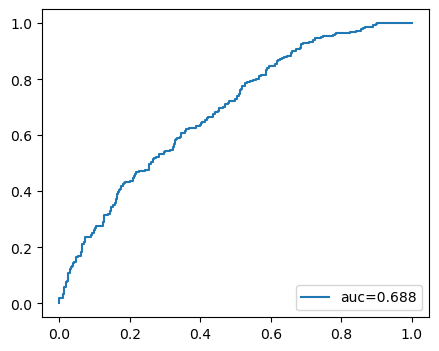

In [810]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

## QDR
qdr = QuadraticDiscriminantAnalysis(store_covariance=True)
qdr.fit(X_train,y_train)

# Get predicted probabilities
# Although Clapper is the positive class, it's the first class returned by predict_proba
y_pred_proba = qdr.predict_proba(X_train)
y_pred_proba_Clapper = qdr.predict_proba(X_train)[::,0]
y_pred_proba_King = qdr.predict_proba(X_train)[::,1]

# Model Score
fpr, tpr, thresholds = roc_curve(y_train,  y_pred_proba_Clapper, pos_label='Clapper')
print("Score:", '{:.3f}'.format(round(qdr.score(X_train, y_train),3)))
print("AUC:", '{:.3f}'.format(round(auc(fpr, tpr), 3)))

plt.rcParams["figure.figsize"] = (5,4)
plt.plot(fpr,tpr,label="auc="+str(round(auc(fpr, tpr), 3)))
plt.legend(loc=4)
'';

              precision    recall  f1-score   support

     Clapper      0.574     0.503     0.536       147
        King      0.541     0.610     0.573       141

    accuracy                          0.556       288
   macro avg      0.557     0.557     0.555       288
weighted avg      0.558     0.556     0.554       288



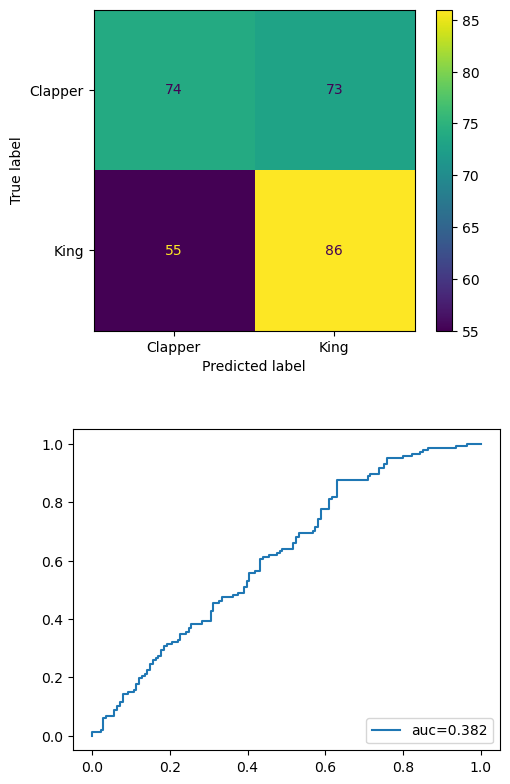

In [ ]:
predictions = qdr.predict(X_test)

# Get predicted probabilities
# Although Clapper is the positive class, it's the first class returned by predict_proba
y_pred_proba = ldr.predict_proba(X_test)
y_pred_proba_Clapper = ldr.predict_proba(X_test)[::,0]
y_pred_proba_King = ldr.predict_proba(X_test)[::,1]

class_rpt = classification_report(y_test, predictions, digits=3, output_dict=True)
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba_Clapper, pos_label='Clapper')
scr_accuracy = round(class_rpt['accuracy'],3)
scr_precision = round(class_rpt['Clapper']['precision'],3)
scr_sensitivity = round(class_rpt['Clapper']['recall'], 3)
scr_specificity = round(class_rpt['King']['recall'], 3)
scr_auc = round(auc(fpr, tpr), 3)
scr_k = round(cohen_kappa_score(y_test, predictions), 3)

print("Accuracy:", '{:.3f}'.format(scr_accuracy))
print("Precision:", '{:.3f}'.format(scr_precision))
print("Sensitivity:", '{:.3f}'.format(scr_sensitivity))
print("Specificity:", '{:.3f}'.format(scr_specificity))
print("AUC:", '{:.3f}'.format(scr_auc))
print("K:", '{:.3f}'.format(scr_k))

fig, axes = plt.subplots(2 ,figsize=(5,8))
fig.tight_layout(h_pad=5, w_pad=5)

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=qdr.classes_)
disp.plot(ax=axes[0])
axes[1].plot(fpr,tpr,label='auc='+'{:.3f}'.format(scr_auc))
plt.legend(loc=4)
'';

***
Logistic Regression
***

Coefficients: 
 [[-0.23856033  0.26644154  0.1515885   0.30429646 -0.42150348]]
Intercept: 
 [0.03635416]
Score: 0.585
AUC: 0.654


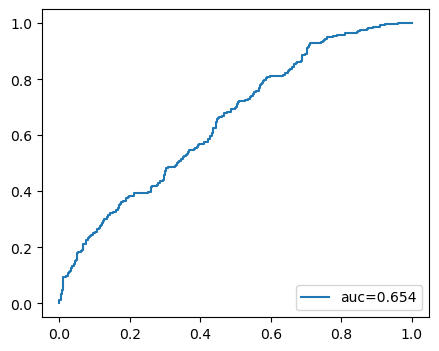

In [811]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

# Get predicted probabilities
# Although Clapper is the positive class, it's the first class returned by predict_proba
y_pred_proba = lr.predict_proba(X_train)
y_pred_proba_Clapper = lr.predict_proba(X_train)[::,0]
y_pred_proba_King = lr.predict_proba(X_train)[::,1]

# The coefficients and intercept
print("Coefficients: \n", lr.coef_)
print("Intercept: \n", lr.intercept_)

# Model Score
fpr, tpr, thresholds = roc_curve(y_train,  y_pred_proba_Clapper, pos_label='Clapper')
print("Score:", '{:.3f}'.format(round(lr.score(X_train, y_train),3)))
print("AUC:", '{:.3f}'.format(round(auc(fpr, tpr), 3)))

plt.rcParams["figure.figsize"] = (5,4)
plt.plot(fpr,tpr,label="auc="+str(round(auc(fpr, tpr), 3)))
plt.legend(loc=4)
'';

              precision    recall  f1-score   support

     Clapper      0.544     0.463     0.500       147
        King      0.515     0.596     0.553       141

    accuracy                          0.528       288
   macro avg      0.530     0.529     0.526       288
weighted avg      0.530     0.528     0.526       288



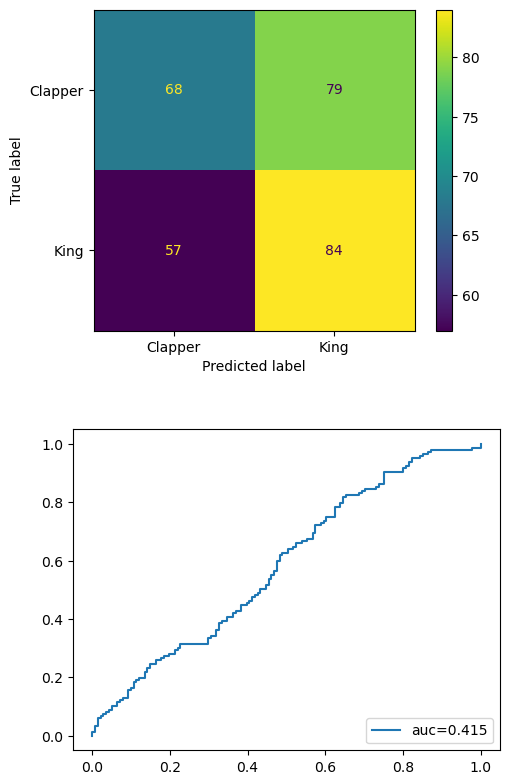

In [ ]:
predictions = lr.predict(X_test)

# Get predicted probabilities
# Although Clapper is the positive class, it's the first class returned by predict_proba
y_pred_proba = ldr.predict_proba(X_test)
y_pred_proba_Clapper = ldr.predict_proba(X_test)[::,0]
y_pred_proba_King = ldr.predict_proba(X_test)[::,1]

class_rpt = classification_report(y_test, predictions, digits=3, output_dict=True)
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba_Clapper, pos_label='Clapper')
scr_accuracy = round(class_rpt['accuracy'],3)
scr_precision = round(class_rpt['Clapper']['precision'],3)
scr_sensitivity = round(class_rpt['Clapper']['recall'], 3)
scr_specificity = round(class_rpt['King']['recall'], 3)
scr_auc = round(auc(fpr, tpr), 3)
scr_k = round(cohen_kappa_score(y_test, predictions), 3)

print("Accuracy:", '{:.3f}'.format(scr_accuracy))
print("Precision:", '{:.3f}'.format(scr_precision))
print("Sensitivity:", '{:.3f}'.format(scr_sensitivity))
print("Specificity:", '{:.3f}'.format(scr_specificity))
print("AUC:", '{:.3f}'.format(scr_auc))
print("K:", '{:.3f}'.format(scr_k))

fig, axes = plt.subplots(2 ,figsize=(5,8))
fig.tight_layout(h_pad=5, w_pad=5)

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=lr.classes_)
disp.plot(ax=axes[0])
axes[1].plot(fpr,tpr,label='auc='+'{:.3f}'.format(scr_auc))
plt.legend(loc=4)
'';

#### Non-Parametric Models

In [465]:
from sklearn.neighbors import KNeighborsClassifier

error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    # knn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    # knn.fit(X_train,y_train)
    # pred_i = knn.predict(X_test)
    knn.fit(X_scaled_train,y_train)
    pred_i = knn.predict(X_scaled_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

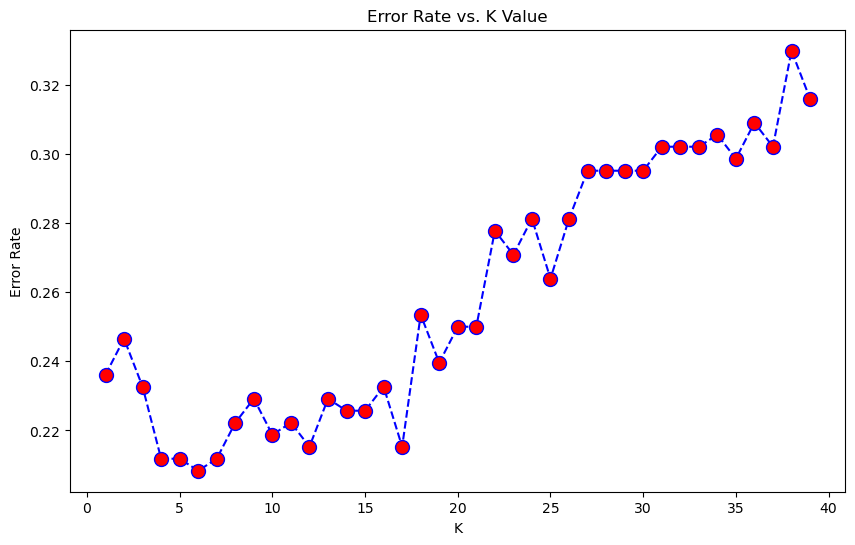

In [466]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [467]:
knn = KNeighborsClassifier(n_neighbors=4)
# knn = KNeighborsClassifier(n_neighbors=4, weights='distance')

knn.fit(X_scaled_train,y_train)
pred = knn.predict(X_scaled_test)

print('WITH K=5')
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

WITH K=5
[[131  16]
 [ 45  96]]
              precision    recall  f1-score   support

     Clapper       0.74      0.89      0.81       147
        King       0.86      0.68      0.76       141

    accuracy                           0.79       288
   macro avg       0.80      0.79      0.79       288
weighted avg       0.80      0.79      0.79       288



In [468]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
# rfc.fit(X_train, y_train)
# rfc_pred = rfc.predict(X_test)
rfc.fit(X_scaled_train, y_train)
rfc_pred = rfc.predict(X_scaled_test)
print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test,rfc_pred))

[[120  27]
 [ 18 123]]
              precision    recall  f1-score   support

     Clapper       0.87      0.82      0.84       147
        King       0.82      0.87      0.85       141

    accuracy                           0.84       288
   macro avg       0.84      0.84      0.84       288
weighted avg       0.85      0.84      0.84       288



In [469]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['linear', 'poly', 'rbf']} 
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=1)
# grid.fit(X_train,y_train)
grid.fit(X_scaled_train,y_train)

print(grid.best_params_)
print(grid.best_estimator_)

# grid_predictions = grid.predict(X_test)
grid_predictions = grid.predict(X_scaled_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=10, gamma=1)
[[106  41]
 [ 28 113]]
              precision    recall  f1-score   support

     Clapper       0.79      0.72      0.75       147
        King       0.73      0.80      0.77       141

    accuracy                           0.76       288
   macro avg       0.76      0.76      0.76       288
weighted avg       0.76      0.76      0.76       288

